# Digit Recognizer

*Chris Daly*

*18/10/2016*

## Introduction

<img src="../images/design.jpg"> 


In this project I will tackle a current Kaggle competition to classify images of handwritten digits.

After relying on sci-kit learn's library for so long I decided it would be a good idea to make my own functions for loading/splitting/outputting the data and to create a classifier from scratch. Doing this allowed me to understand how the algorithms underlying the machine learning models really work and gain an appreciation for vectorized operations and the time they save. 

https://www.kaggle.com/c/digit-recognizer

## Libraries

In [1]:
import numpy as np
import random
import time
from collections import Counter
import matplotlib.pyplot as plt

%matplotlib inline

## Loading the data

Data taken from https://www.kaggle.com/c/digit-recognizer

Note: I tried to use the full dataset but the computing the dot product of matrics with million of values was too much for my poor laptop. To accomodate this I cut down the original training data using linux commands from 42,000 rows to 1000:

```
$ wc -l train.csv
>>> 42001 train.csv

$ head -n 1000 train.csv > train_first1000.csv
```

In [2]:
def load_train_data(data_dir, train_file):
    """
    Loads the training file file into numpy arrays from given
    directory.
    
    Separates out the header, and the data from target.
    """
    # Read in train file.
    train_data = open(data_dir + train_file).read()
    
    # Split rows based on newline character.
    train_data = train_data.split("\n")
    
    # The first row is the header.
    header = train_data[0].split(',')
    
    # From row 1 to the end is the data.
    train_data = train_data[1:-1]
    
    # Inside each row, split values based on commas.
    train_data = [i.split(",") for i in train_data]
    
    # y is the first column, X is the rest of the columns.
    # Convert values from string to integers and store them in numpy arrays.
    y = np.array([int(i[0]) for i in train_data])
    X = np.array([[int(i[j]) for j in range(1,len(i))] for i in train_data])

    return header, X, y

In [3]:
# Directory and file details.
data_dir = "../data/"
train_file = "train_first1000.csv" #"train.csv"

In [4]:
# Load in using function.
header, X, y = load_train_data(data_dir, train_file)

In [5]:
# Inspecting the header.
print header[0:5], header[-5:-1]

['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3'] ['pixel779', 'pixel780', 'pixel781', 'pixel782']


In [102]:
X[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0, 188, 255,  94,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0, 191, 250, 253,  93,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [7]:
X.shape

(999, 784)

The reduced data files contains 999 instances of digits. The first column "label" is the actual class of the hand-drawn digit, from zero through nine. The proceeding columns make-up the image. Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

## Exploratory data analysis

C:\Users\Chris\AppData\Local\Continuum\Anaconda\lib\site-packages\matplotlib\transforms.py:1018: RuntimeWarning: invalid value encountered in not_equal
  if np.any(self._points != other.get_points()):
C:\Users\Chris\AppData\Local\Continuum\Anaconda\lib\site-packages\matplotlib\transforms.py:1563: RuntimeWarning: invalid value encountered in equal
  return np.all(self.get_matrix() == other.get_matrix())


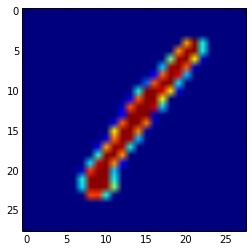

In [8]:
# Use matplotlibs imshow to plot pixels.
plt.imshow(X[0].reshape((28, 28)))

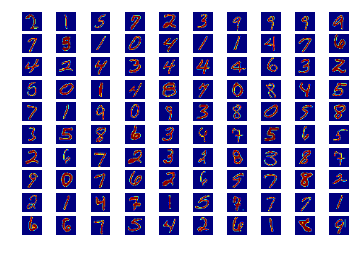

In [103]:
# Number of images on perimeter of plot.
L = 10

# Loop through subplots.
for i in range(0, L*L):
    
    # Designate spot for subplot.
    plt.subplot(L, L, i+1)
    
    # Take random images from X, reshape the image into a 
    # thumbnail and plot it.
    plt.imshow(X[random.randint(0,699),:].reshape([28,28]))
    plt.axis('off')
        
plt.show()

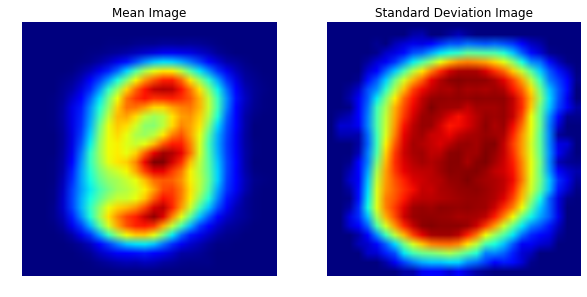

In [10]:
# Calculate the mean and standard deviation of each pixel.
mean_img = np.mean(X, axis=0)
std_img = np.std(X, axis=0)

# Setup plot.
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(mean_img.reshape([28,28]))
plt.title('Mean Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(std_img.reshape([28,28]))
plt.title('Standard Deviation Image')
plt.axis('off')
plt.show()

## Splitting the data

In [11]:
# Set random seed for reproducibility.
np.random.seed(0)

# Take a list of the indices and randomize the order.
indices = np.random.permutation(X.shape[0])

In [12]:
# Set the proportion of data saved for testing purposes.
test_proportion = 0.3

# Get the amount that corresponds to proportion
test_amount = int(X.shape[0] * test_proportion)
train_amount = X.shape[0] - test_amount

In [13]:
# Take the first 70% of indices as training, last 30% as testing.
training_idx, test_idx = indices[:train_amount], indices[test_amount:]

In [14]:
# Split the data and target into training and testing.
X_train, X_test, y_train, y_test = X[training_idx,:], X[test_idx,:], y[training_idx], y[test_idx]

## Defining KNN model

I decided to go with K-nearest neighbors with L2 distance as it scores well without any preprocessing on the the MNIST database of handwritten digits. (http://yann.lecun.com/exdb/mnist/)

### L2 distance

I want to compute the Euclidean distance matrix operation in one entirely vectorized operation, where dist[i,j] contains the distance between the ith instance in A and jth instance in B. 

<img src="../images/1.png"> 

This operation is difficult when A and B are not compatible array sizes and it involves intermediete arrays and broadcasting. This can be done using two or one explicit loops in python which is quite an expensive computation.

Fortunately, since the computation centers on the sum-of-squared-differences, I can take advantage of the mathematical fact that sum-of-squared-differences can be rewritten.

<img src="../images/2.png"> 

Note that the middle term involves the sum over element-wise multiplication. This sum over multiplications is better known as a dot product. Because A and B are each a matrix, then this operation is actually a matrix multiplication. I can thus rewrite the above as:

<img src="../images/3.png"> 

The above term is entirely vectorized as it uses zero explicit loops in python. This greatly increases performance.

### KNN classifier

In [35]:
class KNearestNeighbor():
    """ 
    A kNN classifier with L2 euclidean distance. 
    """
    def __init__(self):
        pass

    def train(self, X, y):
        """
        Trains the classifier. For k-nearest neighbors this is just 
        memorizing the training data.
        
        Inputs:
        
        - X: A numpy array of shape (num_train, D) containing the training data
          consisting of num_train samples each of dimension D.
        - y: A numpy array of shape (N,) containing the training labels, where
             y[i] is the label for X[i].
        """
        # Remember the training data.
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1, num_loops=0):
        """
        Predict labels for test data using this classifier.
        
        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data consisting
             of num_test samples each of dimension D.
        - k: The number of nearest neighbors that vote for the predicted labels.
        - num_loops: Determines which implementation to use to compute distances
          between training points and testing points.
          
        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].  
        """
        # Compute the distance between each point.
        if num_loops == 0:
          dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
          dists = self.compute_distances_one_loop(X)
        elif num_loops == 2:
          dists = self.compute_distances_two_loops(X)
        else:
          raise ValueError('Invalid value %d for num_loops' % num_loops)

        # Init array to hold label predictions.
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)

        for i in range(num_test):
            
            # Init array to hold k closest labels.
            k_closest_y = []
            
            # Sort dists and take corresponding labels.
            labels = self.y_train[np.argsort(dists[i,:])].flatten()
            
            # Find k nearest labels.
            k_closest_y = labels[:k]

            # Take most common label. In case of a tie take the smaller value.
            c = Counter(k_closest_y)
            y_pred[i] = c.most_common(1)[0][0]

        return y_pred
    
    def compute_distances_two_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a nested loop over both the training data and the 
        test data.

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data.

        Returns:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          is the Euclidean distance between the ith test point and the jth training
          point.
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in xrange(num_test):
          for j in xrange(num_train):

            # Take the difference between points, square it, square root.
            dists[i, j] = np.linalg.norm(X[i ]- self.X_train[j])

        return dists

    def compute_distances_one_loop(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a single loop over the test data.

        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in xrange(num_test):

          # Take the difference between the test point and all of the training points, 
          #square it, square root.  
          dists[i,:] = np.linalg.norm(np.abs(X[i] - self.X_train),axis=1)

        return dists
    
    def compute_distances_no_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a nested loop over both the training data and the 
        test data.
        
        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data.
        
        Returns:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          is the Euclidean distance between the ith test point and the jth training
          point.
        """
        # Number of test and training points.
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        
        # Init empty array to hold distances.
        dists = np.zeros((num_test, num_train)) 

        # Dot product between points.
        dot_pro = np.dot(X, self.X_train.T)
        
        # Test and train matrices squared.
        sum_square_test = np.square(X).sum(axis = 1)
        sum_square_train = np.square(self.X_train).sum(axis = 1)
        
        # Vectorized Euclidean distance. (http://stackoverflow.com/posts/37903795/revisions)
        dists = np.sqrt(-2 * dot_pro + sum_square_train + np.matrix(sum_square_test).T)
        
        return dists

## Verifying consistency of different computations

In [41]:
# Calculate distances using each method.
dists_two = classifier.compute_distances_two_loops(X_test)
dists_one = classifier.compute_distances_one_loop(X_test)
dists_zero = classifier.compute_distances_no_loops(X_test)

In [43]:
# Check diff between two loops and one.
difference_two_one = np.linalg.norm(dists_two - dists_one, ord='fro')
print 'Difference was: %f' % (difference_two_one)

# Check diff between two loops and zero.
difference_two_zero = np.linalg.norm(dists_two - dists_zero, ord='fro')
print 'Difference was: %f' % (difference_two_zero)

Difference was: 0.000000
Difference was: 0.000000


Each method results in the same distances between images. Now it's time to compare the speed difference.

## Comparing time of different computations

In [44]:
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) 
  that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print 'Two loop version took %f seconds' % two_loop_time

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print 'One loop version took %f seconds' % one_loop_time

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print 'No loop version took %f seconds' % no_loop_time

Two loop version took 14.147000 seconds
One loop version took 14.342000 seconds
No loop version took 1.810000 seconds


## Training the model

In [107]:
# Set number of nearest neighbours to take.
k = 3

# Initialize KNN classiier.
classifier = KNearestNeighbor()

# Train the model.
classifier.train(X_train, y_train)

## Evaluating the model

In [108]:
# Use trained model to find closest neighbors and predict label.
predictions = classifier.predict(X_test, k, num_loops=0)

In [109]:
# Basic accuracy.
accuracy = (predictions == y_test).sum() / float(len(predictions)) * 100
print "{0:.2f}%".format(accuracy)

89.29%


C:\Users\Chris\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in equal
  from ipykernel import kernelapp as app


### Cross-validation

I've implemented the k-Nearest Neighbor classifier but I set the value k = 5 arbitrarily. I'll now determine the best value of this hyperparameter with cross-validation.

Note: having the same training and testing set from earlier is not neccessary here.

In [110]:
# Number of folds, 5 is an industry standard that works well.
num_folds = 5

# Diverse range of K values, less specific to use distinct values
# rather than a range but it's quicker and can perform better on 
# new data.
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

# Init array to hold current folds.
X_train_folds = []
y_train_folds = []

# Use numpy method to split X, y into consistent random folds.
X_train_folds = np.array_split(X, num_folds)
y_train_folds = np.array_split(y, num_folds)

# Dict to hold values, k: % accuracy.
k_to_accuracies = {}

# For each k.
for k in k_choices:
    
    # For each fold.
    for fold in range(num_folds):
        
        # Subset on the testing fold.
        fold_x_test  = X_train_folds[fold]
        fold_y_test  = y_train_folds[fold]
        
        # Subset on the remaining folds and concatenate the results.
        fold_x_train = np.concatenate(tuple([X_train_folds[i] for i in range(num_folds) if i!=fold]))
        fold_y_train = np.concatenate(tuple([y_train_folds[i] for i in range(num_folds) if i!=fold]))  
        
        # Train the classifer.
        classifier.train(fold_x_train, fold_y_train)
        
        # Make predictions.
        y_test_pred = classifier.predict(fold_x_test, k=k)
        
        # Get the number of correct predictions.
        num_correct = np.sum(y_test_pred == fold_y_test)
        
        # If the fold  has a k (e.g. k=3) that is not already in the dict then 
        # create a key for it.
        if k not in k_to_accuracies:
            k_to_accuracies[k] = [float(num_correct) / fold_x_test.shape[0]]
            
        # Otherwise append new fold to that k. 
        else:
            k_to_accuracies[k].append(float(num_correct) / fold_x_test.shape[0])

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print 'k = %d, accuracy = %f' % (k, accuracy)

C:\Users\Chris\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:41: RuntimeWarning: invalid value encountered in equal


k = 1, accuracy = 0.855000
k = 1, accuracy = 0.855000
k = 1, accuracy = 0.850000
k = 1, accuracy = 0.845000
k = 1, accuracy = 0.869347
k = 3, accuracy = 0.855000
k = 3, accuracy = 0.860000
k = 3, accuracy = 0.850000
k = 3, accuracy = 0.835000
k = 3, accuracy = 0.839196
k = 5, accuracy = 0.835000
k = 5, accuracy = 0.855000
k = 5, accuracy = 0.840000
k = 5, accuracy = 0.850000
k = 5, accuracy = 0.824121
k = 8, accuracy = 0.825000
k = 8, accuracy = 0.840000
k = 8, accuracy = 0.815000
k = 8, accuracy = 0.840000
k = 8, accuracy = 0.834171
k = 10, accuracy = 0.825000
k = 10, accuracy = 0.835000
k = 10, accuracy = 0.805000
k = 10, accuracy = 0.830000
k = 10, accuracy = 0.804020
k = 12, accuracy = 0.845000
k = 12, accuracy = 0.815000
k = 12, accuracy = 0.790000
k = 12, accuracy = 0.845000
k = 12, accuracy = 0.804020
k = 15, accuracy = 0.830000
k = 15, accuracy = 0.815000
k = 15, accuracy = 0.790000
k = 15, accuracy = 0.825000
k = 15, accuracy = 0.788945
k = 20, accuracy = 0.795000
k = 20, accu

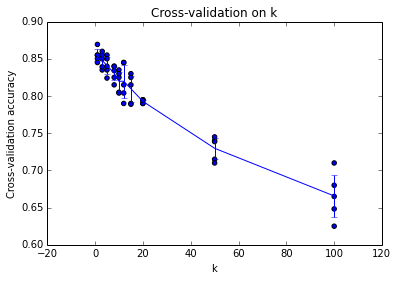

In [111]:
# Plot the raw observations.
for k in k_choices:
    
    # Get the 5 (folds) accuracacies for that k.
    accuracies = k_to_accuracies[k]
    
    # Plot a point for each accuracy.
    plt.scatter([k] * len(accuracies), accuracies)

# Get the mean and std accuracy for the accuracies of each K.
accuracies_mean = np.array([np.mean(value) for key, value in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(value) for key, value in sorted(k_to_accuracies.items())])

# Plot the trend line with error bars that correspond to standard deviation.
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [112]:
zip(k_choices, accuracies_mean, accuracies_std)

[(1, 0.85486934673366832, 0.0081331840698500649),
 (3, 0.84783919597989943, 0.009416809228880562),
 (5, 0.84082412060301515, 0.010943119982557649),
 (8, 0.83083417085427125, 0.0096324121618867296),
 (10, 0.81980402010050246, 0.012885380454955599),
 (12, 0.81980402010050246, 0.022046156795889657),
 (15, 0.80978894472361806, 0.017280636225962001),
 (20, 0.79279396984924622, 0.0023120711686847781),
 (50, 0.72973869346733677, 0.014319462062618976),
 (100, 0.66564824120603017, 0.028735887291043843)]

It's a close call here between K = 1, 3, 5, 8. 

K = 1 has the smallest average accuracy and the smallest standard deviation amongst its competitors. However, while this value produces a model with a high accuracy (bias) it may not do well on new data (variance). After testing out different values I settled on K = 5.

In [124]:
# Use trained model to find closest neighbors and predict label.
predictions = classifier.predict(X_test, k=5, num_loops=0)

# Basic accuracy.
accuracy = (predictions == y_test).sum() / float(len(predictions)) * 100
print "{0:.2f}%".format(accuracy)

88.57%


C:\Users\Chris\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in equal


## Confusion matrix

In [125]:
# Setup empty matrix 10x10.
cm = np.zeros((10, 10))

# Loop through dict of {actual label: predicted label}
for actual, predicted in zip(y_test, predictions):
    
    # For each key-val pair increment the value the corresponding
    # cell in the confusion matrix.
    cm[actual][predicted] += 1

C:\Users\Chris\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [126]:
cm

array([[ 74.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.],
       [  0.,  65.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.],
       [  1.,   4.,  73.,   1.,   0.,   0.,   0.,   3.,   2.,   0.],
       [  0.,   1.,   1.,  57.,   0.,   0.,   0.,   1.,   3.,   0.],
       [  0.,   0.,   0.,   0.,  57.,   0.,   1.,   2.,   0.,  11.],
       [  0.,   2.,   0.,   2.,   0.,  58.,   1.,   0.,   1.,   0.],
       [  3.,   1.,   0.,   0.,   1.,   1.,  62.,   0.,   0.,   0.],
       [  0.,   6.,   0.,   0.,   2.,   0.,   0.,  62.,   0.,   5.],
       [  1.,   2.,   0.,   2.,   1.,   4.,   0.,   0.,  47.,   3.],
       [  2.,   0.,   1.,   0.,   0.,   1.,   0.,   3.,   0.,  65.]])

The actual values are the rows and the predicted are the columns, both going from 0-9. For example the digit "7" is correctly predicted 73 times and only incorrectly predicted twice, once  as a "2" and once as a 9". A visualization is needed to show where the model has trouble.

## Visualizing errors

In [127]:
# Mask for the rows the model got wrong.
incorrect_idx = [predictions != y_test]

C:\Users\Chris\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in not_equal
  from ipykernel import kernelapp as app


In [128]:
# Subset data, target, predictions on incorrect ones.
incorrect_data = X_test[incorrect_idx]
incorrect_label = predictions[incorrect_idx]
correct_label = y_test[incorrect_idx]

# Removing trailing 0.
incorrect_label = [int(i) for i in incorrect_label]

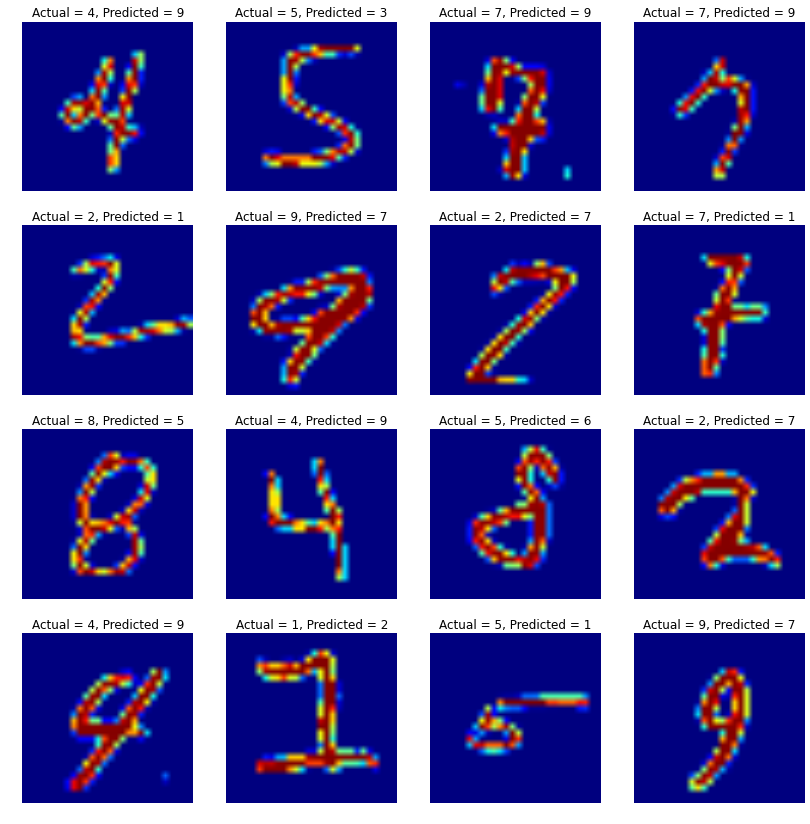

In [129]:
# Number of plots on perimeter.
L = 4

# Set size of plots to be big enough for caption.
plt.figure(figsize=(14, 14))

# Loop through subplots.
for i in range(0, L*L):
    
    # Setup subplot.
    plt.subplot(L, L, i+1)
    
    # Select incorrectly classified rows, reshape them and plot.
    plt.imshow(incorrect_data[i,:].reshape([28,28]))
    plt.title("Actual = {}, Predicted = {}".format(correct_label[i], incorrect_label[i]))
    plt.axis('off')
        
plt.show()

In the first image in this plot it's easy to see how the model thought the "4" was a "9".

## Testing on Kaggle

In [130]:
def load_test_data(data_dir, train_file):
    """
    Loads the testing file into numpy arrays from given
    directory.
    """
    # Same as load_train_data.
    test_data = open(data_dir + test_file).read()
    test_data = test_data.split("\n")[1:-1]
    test_data = [i.split(",") for i in test_data]
    X_test = np.array([[int(i[j]) for j in range(0,len(i))] for i in test_data])

    return X_test

In [131]:
# Directory and file details.
test_file = "test.csv"

# Load in using function.
kaggle_test = load_test_data(data_dir, train_file)

In [132]:
# Predict the classes of kaggle test set.
predictions = classifier.predict(kaggle_test, k)

## Outputting the data

In [133]:
# Write results to file in format specified by Kaggle.
out_file = open("../data/predictions.csv", "w")
out_file.write("ImageId,Label\n")

for i in range(len(predictions)):
    out_file.write(str(i+1) + "," + str(int(predictions[i])) + "\n")
        
out_file.close()

## Conclusions

Using my own simple KNN classifier made from scratch, a basic test/train split and utliizing just 2% of the data, my model achieved an accuracy of 88.01% on Kaggle and a rank of 1139. More data would definitely improve the accuracy of the model by a lot as there may be some unorthodox handwriting in the training data. The model is currently running on 1,000 observations, roughly 100 per digit. Having a couple of bad data points here can easily mislead the model when picking the nearest neighbours.